# 关于星巴克推广活动的实验测试
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
 - 项目源码链接：[Github Repo](https://github.com/NovelAn/Starbucks)

```shell
## 下载源码，请使用以下命令在你的本地上克隆repo

git init
git clone [项目源码链接]

```

 
## 背景信息


该项目将提供一个数据集，星巴克原先使用该数据集作为面试题。该数据集共包含 120,000个数据点，按照 2:1 的比例划分为训练文件和测试文件。数据模拟的实验测试了一项广告宣传活动，看看该宣传活动能否吸引更多客户购买定价为 10 美元的特定产品。由于公司分发每份宣传资料的成本为 0.15 美元，所以宣传资料最好仅面向最相关的人群。每个数据点都有一列表示是否向某个人发送了产品宣传资料，另一列表示此人最终是否购买了该产品。每个人还有另外 7 个相关特征，表示为 V1-V7。
### 评估指标

* **增量响应率 (IRR)** 

IRR 表示与没有收到宣传资料相比，因为推广活动而购买产品的客户增加了多少。从数学角度来说，IRR 等于推广小组的购买者人数与购买者小组客户总数的比例 (_treatment_) 减去非推广小组的购买者人数与非推广小组的客户总数的比例 (_control_)。

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **净增量收入 (NIR)**

NIR 表示分发宣传资料后获得（丢失）了多少收入。从数学角度来讲，NIR 等于收到宣传资料的购买者总人数的 10 倍减去分发的宣传资料份数的 0.15 倍，再减去没有收到宣传资料的购买者人数的 10 倍。

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

## 项目目标

通过训练数据了解 V1-V7 存在什么规律表明应该向用户分发宣传资料从而最大化上述的两个指标。
要详细了解星巴克提供给应聘者的数据集，请参阅[此处的说明](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM)。
下面是训练数据。研究数据和不同的优化策略。

#### 如何测试你的策略？

如果你想到了优化策略，请完成要传递给 `test_results` 函数的 `promotion_strategy` 函数。  
根据以往的数据，我们知道有四种可能的结果：

实际推广客户与预测推广客户表格：  

<table>
<tr><th></th><th colspan = '2'>实际</th></tr>
<tr><th>预测</th><th>是</th><th>否</th></tr>
<tr><th>是</th><td>I</td><td>II</td></tr>
<tr><th>否</th><td>III</td><td>IV</td></tr>
</table>

我们仅针对预测应该包含推广活动的个人比较了指标，即第一象限和第二象限。由于收到宣传资料的第一组客户（在训练集中）是随机收到的，因此第一象限和第二象限的参与者人数应该大致相同。  

比较第一象限与第二象限可以知道宣传策略未来效果如何。 

首先阅读以下数据。看看每个变量或变量组合与推广活动对购买率有何影响。你想到谁应该接收宣传资料的策略后，请使用在最后的 `test_results` 函数中使用的测试数据集测试你的策略。

In [1]:
# load in packages
from itertools import combinations

import statsmodels.api as sm
from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

D:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


# 数据评估和清洗

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.1+ MB


In [3]:
print('重复数值个数:', train_data.duplicated(subset='ID').sum())
print('缺失值个数：',train_data.isnull().sum().sum())

重复数值个数: 0
缺失值个数： 0


In [4]:
for column in train_data.columns:
    print(column)
    print('---')
    print(train_data[column].unique())

ID
---
[     1      3      4 ... 126182 126183 126184]
Promotion
---
['No' 'Yes']
purchase
---
[0 1]
V1
---
[2 3 0 1]
V2
---
[30.4435178 32.1593501 30.4316591 ... 31.4920187 37.7661061 21.7208355]
V3
---
[-1.1650834  -0.6456167   0.13358341 -0.2127277  -0.3858833  -0.90535
  1.08593908 -1.4248168   0.39331678  0.56647235 -1.5113946   0.73962793
  1.60540581 -1.2516612   1.51882802  0.2201612  -0.12615    -1.6845501
 -0.9919278  -0.5590389   1.6919836   0.82620572  0.99936129 -0.4724611
  0.04700562 -1.338239   -1.5979723   0.30673899 -0.0395722   1.34567245
  0.91278351 -0.8187723   1.43225023  1.25909466  1.17251687  0.47989457
 -0.7321945  -1.0785056  -0.2993055   0.65305014]
V4
---
[1 2]
V5
---
[1 3 4 2]
V6
---
[3 2 4 1]
V7
---
[2 1]


有上图可以看出，V2和V3特征上是连续性变量，其他特征可能是分类型变量也可能是具有数字意义的离散型变量

# 显著性检验

## 检查不变指标
检查treat组人数与control组人数的平衡性

- 零假设：p_treat = p_control
- 备择假设：p_treat $\neq$ n_control

In [5]:
train_data.Promotion.value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [6]:
n_total = train_data.shape[0]
n_treat = train_data.Promotion.value_counts()['Yes']
n_control = train_data.Promotion.value_counts()['No']
actual_p_treat = n_treat/n_total
print("样本中treat组人数占总人数的比例：","%.2f"%actual_p_treat)

样本中treat组人数占总人数的比例： 0.50


In [7]:
import scipy.stats as stats

p_treat_null = 0.5
std_treat_null = np.sqrt(p_treat_null * (1 - p_treat_null)/n_total)
null_dist = stats.norm(loc=p_treat_null, scale=std_treat_null)
p_val = (1 - null_dist.cdf(actual_p_treat)) * 2
p_val

0.5046149723893156

p_val = 0.5046 > $\alpha = 0.05 $， 所以不拒绝原假设，即treat组人数和control组人数是相等的

## 检验评估指标

**增量响应率**
$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

**净增量收入**
$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$


检验评估指标$IRP$是否具有统计显著性，检查$NIR$是否具有统计功效

In [8]:
# 计算实际IRP
n_treat_purch =train_data.query("Promotion == 'Yes' and purchase == 1").shape[0]
n_ctrl_purch =train_data.query("Promotion == 'No' and purchase == 1").shape[0]

In [9]:
irp, nir = score(train_data)
irp, nir

(0.009454547819772702, -2334.5999999999995)

### IRP的统计显著性检验
- 零假设：IRP = 0
- 备择假设：IRP > 0

由于上述样本量都大于30，所以treat组的购买率与control组的购买率的抽样分布均服从正态分布

In [10]:
# 使用statsmodel.proportions_ztest进行irp的显著性统计检验
zstat, p_val = sm.stats.proportions_ztest([n_treat_purch, n_ctrl_purch],[n_treat,n_control], alternative='larger')

In [11]:
print("p_val_irf:","%.2f"%p_val)

p_val_irf: 0.00


p_val = 0.0 < 𝛼=0.05 ， 所以拒绝原假设，即treat组的购买率大于control组购买率，即通过推广活动确实有助于提高销售率

### NIR的统计显著性的检验
- 零假设：NIR <= 0
- 备择假设：NIR > 0 <br>

等同于：
- 零假设：IRP <= 1.5%
- 备择假设：IRP > 1.5%

当检测到$NIR>0$具有统计显著性时，希望能够有80%的置信度能够检测到1.5%的绝对增加量，即功效为 $1-\beta = .80$，I 型错误率为 $\alpha = .05$。

In [12]:
sample_purch_p = (n_ctrl_purch + n_treat_purch)/n_total
sample_purch_p

0.012302742091939338

In [13]:
# # 计算计算该统计功效所需要的样本量
# from statsmodels.stats.power import NormalIndPower
# from statsmodels.stats.proportion import proportion_effectsize
# irp_null = 0
# irp_alt = 0.015

# # leave out the "nobs" parameter to solve for it
# needed_sample_size = NormalIndPower().solve_power(effect_size = proportion_effectsize(.01123+0.015, .01123), alpha = .05, power = 0.8,
#                              alternative = 'larger')
# needed_sample_size

In [14]:
# 计算零假设irp = 1.5%的前提下，检测到样本的irp的概率
irp_mean_null = 0.015

zstat, p_val = sm.stats.proportions_ztest([n_treat_purch, n_ctrl_purch],[n_treat,n_control], value=irp_mean_null, alternative='larger')
p_val

0.9999999999998695

- p_val = 1 > $\alpha = 0.05$，所以不拒绝原假设，即假设$IRP = 1.5$%，也就是假设$NIR = 0$的情况下，能够检测到该样本的IRP的概率约为1;
- 所以，本次的推广活动虽然能够提高销售量，但是并不能带来实际增收，因为销售量的增加所带来的收入小于因为推广而增加的成本;

# 探索性分析

通过上述显著性检测可以得知，本推广活动虽然能够起到推广效果，即能够增加销售量，但是相比于因为推广而产生的成本，增加程度有限。如果不对该推广活动进行优化而施行下去，只会导致成本增加的越来越多，亏损越来越大，所以需要通过对本次推广活动中购买者和未购买用户的用户属性进行分析，从而制定出更好的推广策略。

## 单变量分析
分别观察分类型变量在不同属性上的购买率分布和连续性变量在购买人数的分布

In [15]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


### 分析离散型变量在购买率上的差异

In [16]:
train_data[['V1','V4', 'V5', 'V6','V7']] = train_data[['V1','V4', 'V5', 'V6','V7']].applymap(lambda x:str(x))
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  object 
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  object 
 7   V5         84534 non-null  object 
 8   V6         84534 non-null  object 
 9   V7         84534 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 4.5+ MB


In [17]:
# ['V1','V4', 'V5', 'V6','V7']是离散型变量特征，purchase是标签
discret_val = train_data[['purchase','V1','V4', 'V5', 'V6','V7']]

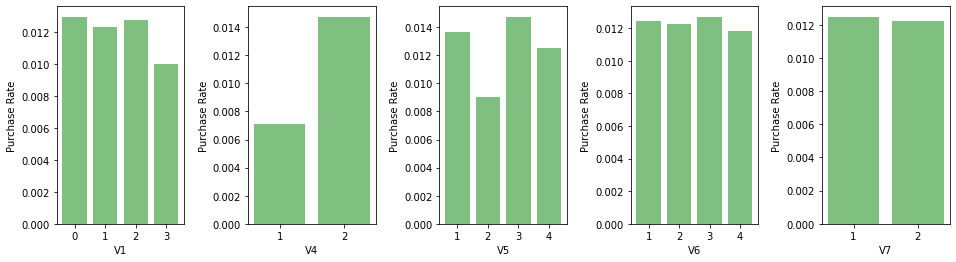

In [18]:
discret_features = np.array(['V1','V4', 'V5', 'V6','V7'])
fig,axes = plt.subplots(1, 5, figsize=(16,4))
for i,feature in enumerate(discret_features):
    # 可视化各个分类特征中在不同属性上的购买率分布
    data = (discret_val \
        .query("purchase == 1").groupby([feature]).size()
        /discret_val.groupby([feature]).size()).reset_index(name="purchase_rate")
    axes[i].bar(feature, 'purchase_rate', color='green', alpha=.5, data=data)
    axes[i].set_xticks(data[feature])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Purchase Rate')
plt.subplots_adjust(wspace=0.5);

从上图可以看出，特征V1，V4，V5在不同的取值上存在着较为差异化分布：

- V1特征中，属性为3的用户，其购买率较低于其他属性；
- V4特征中，属性为2的用户，其购买率明显高于属性1的用户；
- V5特征中，属性为2的用户，其购买率较低于其他属性；
- V6和V7特征中，不同属性的用户，购买率没有较明显的差异；

### 分析连续型变量在购买率上的差异

In [19]:
train_data.describe()

,ID,purchase,V2,V3
count,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,29.973600,0.000190
std,36418.440539,0.110234,5.010626,1.000485
min,1.000000,0.000000,7.104007,-1.684550
25%,31467.250000,0.000000,26.591501,-0.905350
50%,62827.500000,0.000000,29.979744,-0.039572
75%,94438.750000,0.000000,33.344593,0.826206
max,126184.000000,1.000000,50.375913,1.691984


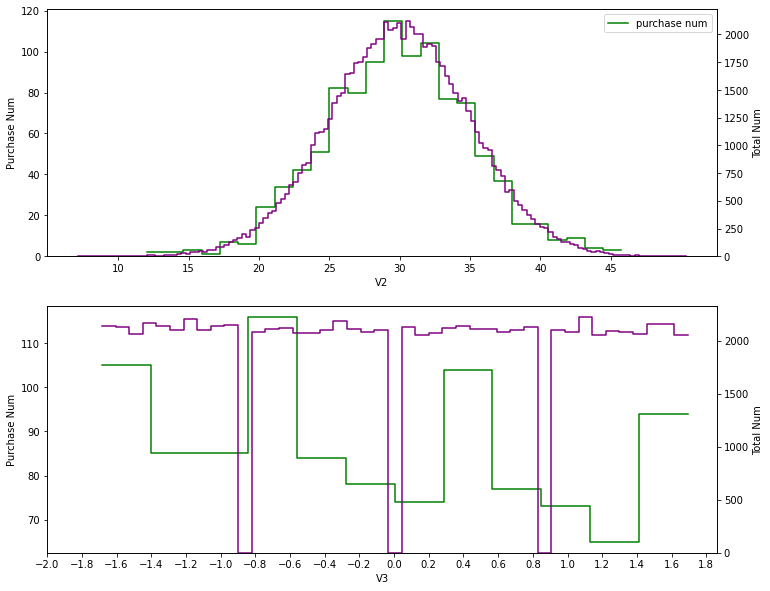

In [20]:
# 用直方图观察连续性变量在购买人数和总人数上的分布
constant_df = train_data[['purchase','V2','V3']]
constant_purch_df = train_data[['purchase','V2','V3']].query("purchase == 1")
fig,axes = plt.subplots(2,1, figsize=(12,10),sharex=False,sharey=False)

# 购买人数和总人数在V2上的分布
sb.histplot(constant_purch_df, x="V2",element="step", ax=axes[0],color='green',fill=False)
axes1 = axes[0].twinx()
sb.histplot(constant_df, x="V2",element="step", ax=axes1,color='purple',fill=False)
axes[0].set(xticks = np.arange(10,50,5),
            xlabel='V2',
            ylabel='Purchase Num')
axes1.set(xticks = np.arange(10,50,5),
            xlabel='V2',
            ylabel='Total Num')

# 购买人数和总人数在V3上的分布
sb.histplot(constant_purch_df, x="V3",element="step", ax=axes[1],color='green',fill=False,);
axes2 = axes[1].twinx()
sb.histplot(constant_df, x="V3",element="step", ax=axes2,color='purple',fill=False)
axes[1].set(xticks = np.arange(-2,2,0.2),
            xlabel='V3',
            ylabel='Purchase Num')
axes2.set(xticks = np.arange(-2,2,0.2),
          xlabel='V3',
          ylabel='Total Num')
axes[0].legend(labels=['purchase num','total num'])
plt.subplots_adjust(hspace=0.2);

从上图可以看出：
- 用户集中分布在V2取值为***（25，35）***区间内，对应的购买人群也较多地分布在该区间内；
- V3特征的取值并非完全连续，其取值范围大致可以分成四个独立区间(-1.8,-1)，(-0.8,0), (0,0.8), (0.8,1.8)每个区间上的用户总人数分布上也相对均匀。从四个区间内的购买人数分布上来看，相对而言，每个区间内都有一个较为集中的购买人群：
    - (-1.8,-1)区间内(-1.8,-1.4)区间内购买人数较多；
    - (-0.8,0)区间内(-0.8,-0.6)区间内购买人数较多，且该区间内的购买人数是整个区间内购买人数最多的区间；
    - (0,0.8)区间内(0.5,0.6)区间内购买人数较多；
    - (0.8,1.8)区间内(1.4,1.8)区间内购买人数较多；

## 双变量分析

### 连续性变量两两分析

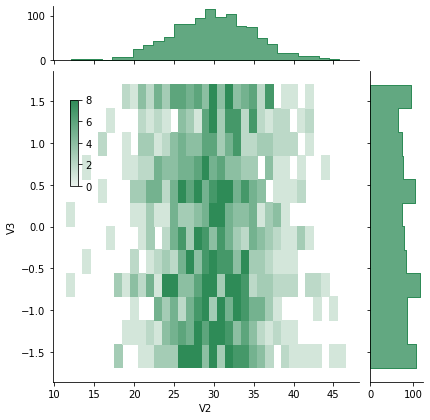

In [21]:
# fig,ax = plt.subplots(figsize=(8,8))
g = sb.JointGrid(data=constant_purch_df, x="V2", y="V3", marginal_ticks=True)
cax = g.fig.add_axes([.15, .55, .02, .2])
g.plot_joint(
    sb.histplot, discrete=(True, False),
    cmap="light:#2E8B57", pmax=.8, cbar=True,cbar_ax=cax
)
g.plot_marginals(sb.histplot, element="step", color="#2E8B57");

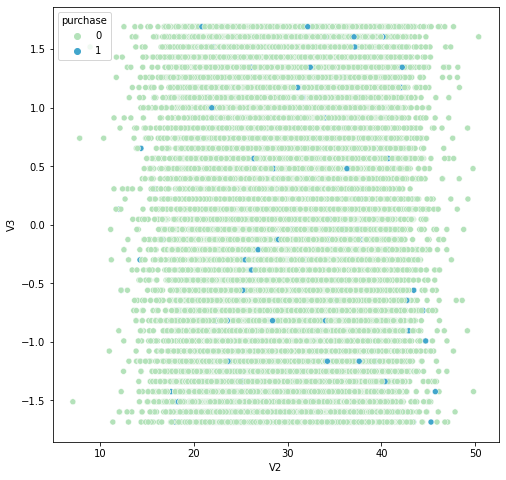

In [211]:
plt.figure(figsize=(8,8))
sb.scatterplot('V2','V3', hue='purchase', palette='GnBu', data=constant_df);

两个连续性变量之间没有明显的相关性，V2特征的分布在V3各个区间都有体现

### 分类型变量与连续性变量之间的分析

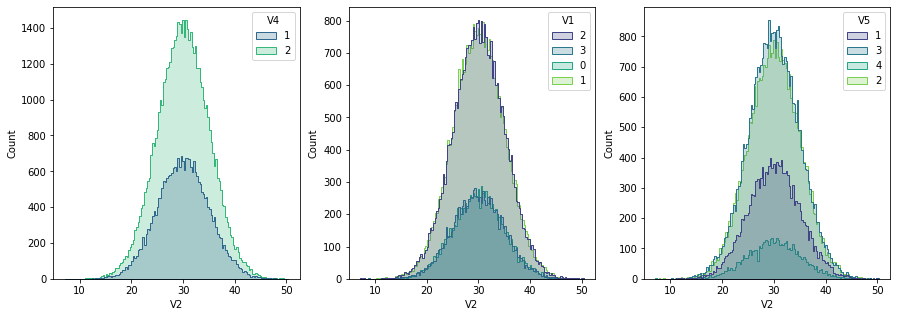

In [22]:
# 分别将特征V1，V4，V5与V2之间作对比

# V2 VS V4
fig, axes = plt.subplots(1,3,figsize=(15,5))
sb.histplot(train_data,
             x="V2",
             hue="V4",
             element='step', palette='viridis',ax=axes[0])

sb.histplot(train_data,
             x="V2",
             hue="V1",
             element="step", palette='viridis',ax=axes[1])
sb.histplot(train_data,
             x="V2",
             hue="V5",
             element="step", palette='viridis',ax=axes[2]);

# 建模

如果需要精准定位客户，意味需要精准定位有消费需求或者购买意愿更加强烈的用户，所以用户的属性与其购买结果可能存在一定的规律和逻辑，下面将使用逻辑回归、决策树、随机森林和支持向量机四种算法探索变量之间的关系，以寻找预测能力较好的算法

In [45]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

## 数据预处理

### 数据不平衡处理

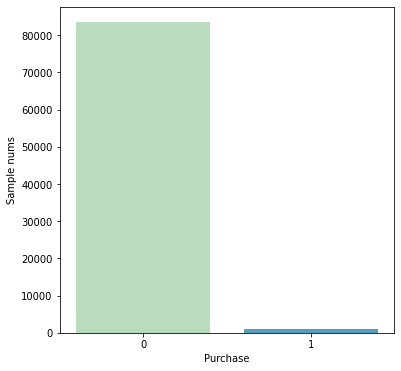

In [25]:
fig,ax = plt.subplots(figsize=(6,6))
purch_dist = train_data.purchase.value_counts()
sb.barplot(x=purch_dist.index,
           y=purch_dist.values,
           palette='GnBu',
           ax=ax)
ax.set(xlabel='Purchase',
       ylabel= 'Sample nums');

正负样本在样本量上差异过于悬殊，如果直接采用整个数据集进行训练，训练出来的预测器极有可能会把所有的用户预测为非购买用户从而使准确率达到最大，但这样的预测器对于本项目没有任何价值。而要解决这一问题，需要利用采样的方式，让正负样本在训练的过程中拥有相同的话语权。

#### 上采样
本项目应为正负样本差异过于悬殊，如果简单地选择同等大小的负样本，容易导致数据缺失严重，而且随机性也比较强，分析出来的结果不够有说服力，所以使用ADASYN算法或SMOTE算法，人工合成新的正例样本

In [220]:
# 采用ADASYN算法，进行数据整合
from imblearn.over_sampling import SMOTE

In [221]:
oversample_features = train_data.drop(['ID','Promotion','purchase'],axis=1)
oversample_labels = train_data['purchase']
oversample = SMOTE(random_state=0)
os_features, os_labels = oversample.fit_resample(oversample_features.values, oversample_labels.values)

### 预处理
本项目因为使用树模型的相关算法去搭建模型，所以预处理这部分用不到，但是如果要使用逻辑回归或SVM，需要对数据预先进行处理，方可传入学习器

In [222]:
# dummy不会对数值型数据产生影响
class pre_precessing(object):
    
    def __init__(self, df):
        
        self.df = df
        
    # 将分类型数据转换成独热编码
    def one_hot_encoder(self, cat_col=None):
        
        if cat_col:    
            cat_data = self.df[cat_col]
        else:
            cat_data = self.df
        self.df = pd.get_dummies(cat_data)
        return self.df
    
    # 将连续性数据做归一化处理
    def scale_data(self, numerical_col):
        
        scale = MinMaxScaler()
        self.df[numerical_col] = scale.fit_transform(self.df[numerical_col])
        
        return self.df

### 拆分数据
将`train_data`按照0.8和0.2的比例分成训练集和验证集

In [240]:
X_train, X_val, y_train, y_val = train_test_split(os_features, os_labels, test_size=0.2, random_state=0)

# 显示切分的结果
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Validation set has {} samples.".format(X_val.shape[0]))

Training set has 133590 samples.
Validation set has 33398 samples.


## 模型性能评价方法的选择
本项目旨在通过模型对用户特征相互关系的探索，探索出购买用户的属性，准确地预测用户购买咖啡意愿，使推广活动能够更加有针对性地开展，提高IRP和NIR。本项目期望的模型是能够精准地预测哪些用户会购买咖啡，所以`precision`和`recall`都是关键指标，所以这里选择***F1_score***作为评价指标：
$$F_1 = 2 * \frac{precision * recall}{precision + recall}$$

## 模型训练
本项目更适于使用树模型相关算法，理由如下:
- 相对于逻辑回归和SVM支持向量机，如决策树、随机森林、Adaboost、CBDT等完全不受数据缩放的影响，不需要对数据进行标准化或归一化；
- 对于本项目的分类型特征，目前尚不能明确这些特征是具有数值意义的有序的分类数据还是无序的分类数据，所以one_hot_encode也不一定能很好代表数值的真实意义，而树模型对分类型数据和连续性数据都能进行很好的分割；
- 由于本项目的原数据集发生了严重的数据不平衡问题，采用人工合成新数据的上采样方式，加以集成学习中的随机bagging能够很好的解决这个问题；

### 决策树

In [231]:
# 直接使用网格搜索，搜索出最佳参数
parameters = {'max_depth': [2,3,4,5],
             'min_samples_split':[4,6,8,10]}
base_estimator = DecisionTreeClassifier(criterion="entropy", )
grid_obj = GridSearchCV(base_estimator, param_grid=parameters, scoring=make_scorer(f1_score), cv=5)
grid_obj.fit(X_train, y_train)
best_clf = grid_obj.best_estimator_
print ("best_clf\n------")
print (best_clf)

y_pred = best_clf.predict(X_val)
print('F1_score on validation: %.2f'%f1_score(y_val, y_pred))
print('Accuracy score on validation: %.2f'%accuracy_score(y_val, y_pred))

Training set has 133590 samples.
Validation set has 33398 samples.
best_clf
------
DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=4)
F1_score on validation: 0.74
Accuracy score on validation: 0.70


In [232]:
# 导出混淆矩阵
print('confusion_matrix:'.title())
print(confusion_matrix(y_val, y_pred))
tn, fp, fn,tp = confusion_matrix(y_val, y_pred).ravel()
print('precision score: %.2f'%(tp/(tp + fp)))
print('recall score: %.2f'%(tp/(tp + fn)))

Confusion_Matrix:
[[ 9470  7145]
 [ 2870 13913]]
precision score: 0.66
recall score: 0.83


### 使用随机森林

In [233]:
parameters = {'max_depth': [2,3,4,5],
             'min_samples_split':[4,6,8,10]}
base_estimator = RandomForestClassifier(criterion="entropy",n_estimators=10)
grid_obj = GridSearchCV(base_estimator, param_grid=parameters, scoring=make_scorer(f1_score), cv=5)
grid_obj.fit(X_train, y_train)
best_clf = grid_obj.best_estimator_
print ("best_clf\n------")
print (best_clf)

y_pred = best_clf.predict(X_val)
print('F1_score on validation: %.2f'%f1_score(y_val, y_pred))
print('Accuracy score on validation: %.2f'%accuracy_score(y_val, y_pred))

best_clf
------
RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=8,
                       n_estimators=10)
F1_score on validation: 0.77
Accuracy score on validation: 0.76


In [234]:
# 导出混淆矩阵
print('confusion_matrix:'.title())
print(confusion_matrix(y_val, y_pred))
tn, fp, fn,tp = confusion_matrix(y_val, y_pred).ravel()
print('precision score: %.2f'%(tp/(tp + fp)))
print('recall score: %.2f'%(tp/(tp + fn)))

Confusion_Matrix:
[[11726  4889]
 [ 3086 13697]]
precision score: 0.74
recall score: 0.82


### 提取特征的重要性
在使用网格搜索之下，相对于决策树，随机森林在验证集上的准确性、精确率和F1分数都有所提高，这是我们想要模型可以达到的，所以本项目选择`best_clf`参数下的随机森林作为模型，以下通过该模型提取特征的重要性：

In [235]:
model = best_clf.fit(X_train, y_train)
importances = model.feature_importances_

In [236]:
indices = np.argsort(importances)[::-1]
columns = oversample_features.columns.values[indices]
sorted_importances = importances[indices]

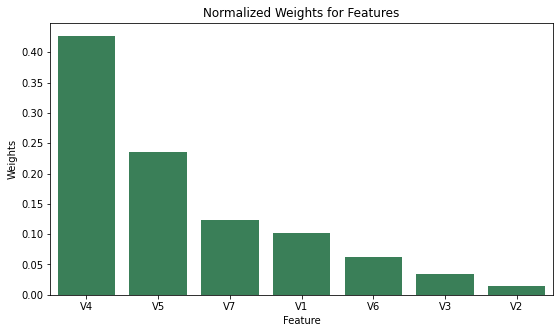

In [237]:
fig,ax = plt.subplots(figsize=(9,5))
sb.barplot(x=columns, y=sorted_importances, color='#2E8B57', ax=ax)
ax.set(title='Normalized Weights for Features',
      ylabel='Weights',
      xlabel='Feature');

通过特征重要性的值可以看出：

- V4和V5的不同也与该用户是否购买咖啡存在一定的相关性

## 测试

In [238]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test_predict = best_clf.predict(df)
    promotion = np.where(test_predict == 0, 'No', 'Yes')
    return promotion

In [239]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0193.

Your nir with this strategy is 234.30.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.019264916612289986, 234.30000000000007)

# 结论

- 从上面测试结果可以看到，模型的使用提高了IRP和NIR，将IRP由原来的0.009提高至0.019，将NIR由原来的-2335提高至234；
- 模型中显示用户是否购买与该用户在V4和V5的属性具有一定的相关性，通过探索性分析部分可得：
    - V4属性为2的用户，其购买率明显高于属性1的用户；
    - V5特征中，属性为2的用户，其购买率较低于其他属性；
    - 所以在实际推广过程可以更多地针对V4属性为2的用户作为主要目标用户，甚至地针对该类群体策划个性化的营销活动，同时也可以减少对于V5属性为2的用户的推广
- 本项目也说明推广活动如果更加能够精准地面向其目标对象，不仅能够较大的提高销量，还能相应地避免成本的浪费，从而使推广活动能够带来实际的收益；